In [1]:
import pandas as pd
import numpy as np
import tqdm
import torch

# Pre processing

In [2]:
import torch
from torch_geometric.data import Data, DataLoader
import os
import os.path as osp
import math
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from graph_data import GraphDataset

gdata = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100)

input_dim = 4
latent_dim = 32
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
batch_size = 32
n_epochs = 20
lr = 0.01
patience = 10
device = 'cuda:0'
model_fname = 'EdgeNetPool'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool

class EdgeNetPool(nn.Module):
    def __init__(self, input_dim=4, latent_dim=32, n_particles=100, aggr='mean'):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_particles = n_particles
        self.aggr = aggr
        super(EdgeNetPool, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(self.input_dim), 64),
                                   nn.ReLU(),
                                   nn.Linear(64, self.latent_dim),
                                   nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, self.n_particles*self.input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.encoder(data.x, data.edge_index)
        data.u = global_mean_pool(data.x, data.batch)
        data.x = self.decoder(data.u)
        data.x = torch.reshape(data.x, (-1, self.input_dim))
        return data.x

In [4]:
model = EdgeNetPool(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [5]:
train_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=0,stop=splits[0])
valid_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[1],stop=splits[2])
test_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[0 ],stop=splits[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)
print(train_dataset[0])

24043
2405
2405
Data(edge_index=[2, 420], x=[100, 4], y=[100, 4])


In [6]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [ ]:
modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
model.load_state_dict(torch.load(modpath))

In [10]:
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

loss = 2123.70605:   1%|          | 4/751.34375 [00:15<49:31,  3.98s/it]


KeyboardInterrupt: 

In [8]:
model.load_state_dict(torch.load(modpath))
input_x = []
output_x = []

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    input_x.append(data.x.cpu().numpy())
    output_x.append(model(data).cpu().detach().numpy())

76it [00:07,  9.73it/s]                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


(240500,)
(240500,)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 5.503e+03, 5.599e+03,
        4.751e+03, 4.153e+03, 3.801e+03, 3.489e+03, 3.197e+03, 2.989e+03,
        2.898e+03, 2.761e+03, 2.490e+03, 2.453e+03, 2.277e+03, 2.211e+03,
        2.197e+03, 2.074e+03, 1.938e+03, 1.792e+03, 1.784e+03, 1.760e+03,
        1.710e+03, 1.590e+03, 1.570e+03, 1.531e+03, 1.431e+03, 1.330e+03,
        1.287e+03, 1.345e+03, 1.346e+03, 1.163e+03, 1.206e+03, 1.154e+03,
        1.084e+03, 1.029e+03, 1.096e+03, 9.930e+02, 9.910e+02, 9.350e+02,
        9.070e+02, 8.990e+02, 8.780e+0

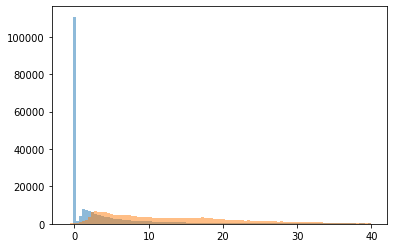

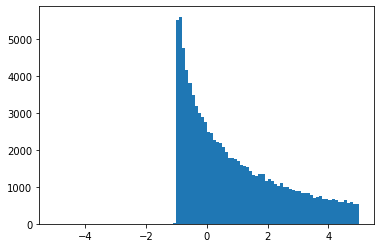

In [9]:
diff = []
output_px = []
input_px = []
for i in range(len(input_x)):
    diff.append(((output_x[i][:,3]-input_x[i][:,3])/input_x[i][:,3]).flatten())
    output_px.append(output_x[i][:,3].flatten())
    input_px.append(input_x[i][:,3].flatten())
    
all_diff = np.concatenate(diff)
all_input_px = np.concatenate(input_px)
all_output_px = np.concatenate(output_px)

print(all_input_px.shape)
print(all_output_px.shape)

plt.figure()
plt.hist(all_input_px, bins=np.linspace(-1, 40, 101),alpha=0.5)
plt.hist(all_output_px, bins=np.linspace(-1, 40, 101),alpha=0.5)

plt.figure()
plt.hist(all_diff, bins=np.linspace(-5, 5, 101))